In [5]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans

import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
from scipy.integrate import odeint
#change path to where 'manuscript_data' is saved
dir_path = '/home/antonio/Repositories/manuscript_data/'
sys.path.append(dir_path+'/code/utils/')
import operator_calculations as op_calc
import stats

# Panel A

In [6]:
k_B_T = 0.5
f = h5py.File(dir_path+'/DoubleWell/simulations/simulation_k_B_T_{}.h5'.format(k_B_T),'r')
sim = np.array(f['simulation'])
T = np.array(f['MetaData/T'])[0]
discard_t = np.array(f['MetaData/discarded_t'])[0]
dt = np.array(f['MetaData/integration_step'])[0]
f.close()

In [4]:
x,y = np.meshgrid(np.linspace(-2,2,100),np.linspace(-4,4,100))

P = (x**2-1)**2 + y**2

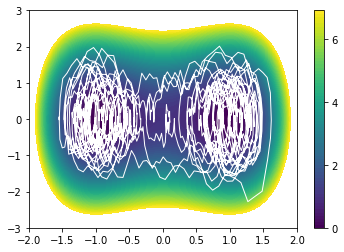

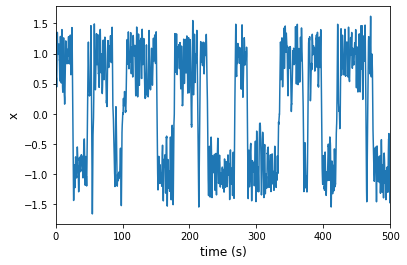

In [5]:
plt.contourf(x,y,P,levels=np.arange(0,7,.1),cmap='viridis')
plt.xlim(-2,2)
plt.ylim(-3,3)
tmax = 10000
tmin = 8000
plt.plot(sim[tmin:tmax,0],sim[tmin:tmax,1],c='w',alpha=1,lw=1)
plt.colorbar(ticks = np.arange(0,7,2))
# plt.savefig('DW_potential_traj.pdf')
plt.show()
plt.plot(np.arange(0,tmax*dt,dt),sim[:tmax,0])
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('x',fontsize=12)
plt.xlim(0,500)
# plt.savefig('DW_x_traj.pdf')
plt.show()

# Panel B - embeddings 

In [7]:
f = h5py.File(dir_path+'/DoubleWell/combined_embedding_results.h5','r')
K_range = np.array(f['K_range'])
T_range = np.array(f['T_range'])
seed_range = np.array(f['seed_range'],dtype=int)[:15]
print(seed_range)
length = np.array(f['length'])[0]
prob_T_K_s = np.array(f['probs'])[:,:,:15,:]
H_T_K_s = np.array(f['entropies'])[:,:,:15,:]
h_T_K_s = np.array(f['entropy_rates'])[:,:,:15,:]
Ipred_T_K_s = np.array(f['Ipreds'])[:,:,:15,:]
eps_T_K_s = np.array(f['eps_scale'])
f.close()

[    3     5    10    17    31    56   100   177   316   562  1000  1778
  3162  5623 10000]


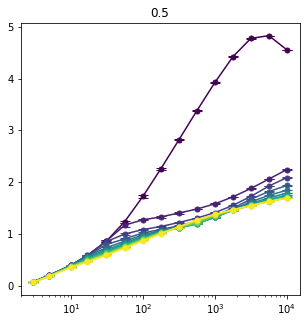

<Figure size 432x288 with 0 Axes>

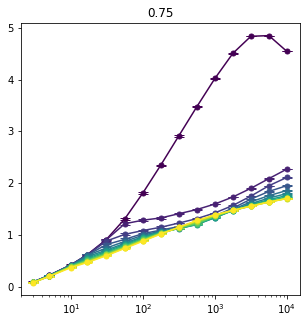

<Figure size 432x288 with 0 Axes>

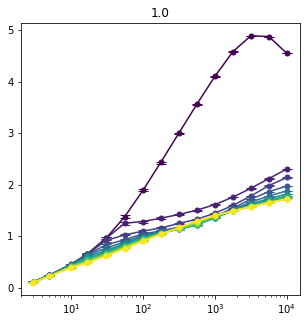

<Figure size 432x288 with 0 Axes>

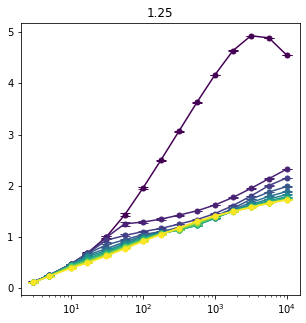

<Figure size 432x288 with 0 Axes>

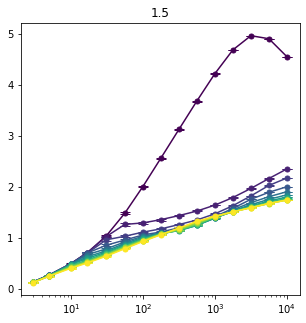

<Figure size 432x288 with 0 Axes>

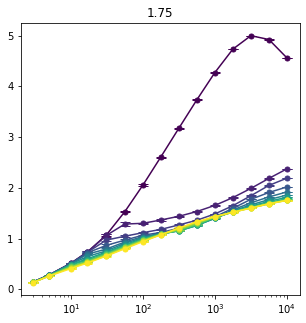

<Figure size 432x288 with 0 Axes>

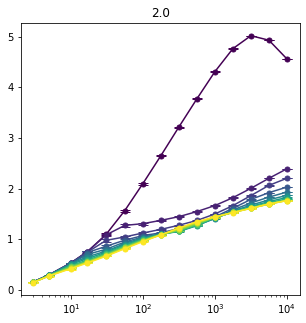

<Figure size 432x288 with 0 Axes>

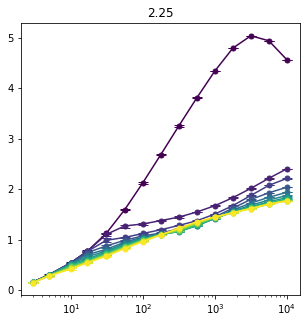

<Figure size 432x288 with 0 Axes>

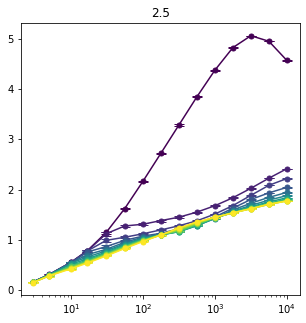

<Figure size 432x288 with 0 Axes>

In [7]:
for kT in range(len(T_range)):
    colors_ = plt.cm.viridis(np.linspace(0,1,12))
    plt.figure(figsize=(5,5))
    plt.title(T_range[kT])
    for k in range(12):
        mean = np.mean(h_T_K_s[kT,k,:,:].T,axis=0)
        cil = np.percentile(h_T_K_s[kT,k,:,:].T,2.5,axis=0)
        ciu = np.percentile(h_T_K_s[kT,k,:,:].T,97.5,axis=0)
        plt.errorbar(seed_range,mean,yerr = [mean-cil,ciu-mean],capsize=5,marker='o',ms=5,c=colors_[k])
    plt.xscale('log')
#     plt.savefig('Embedding_DW_T_{}.pdf'.format(T_range[kT]))
    plt.show()
    plt.clf()

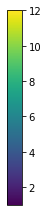

In [8]:
import pylab as pl
import numpy as np

a = np.array([[0,1]])
pl.figure(figsize=(.25, 4.5))
img = pl.imshow(a, cmap="viridis",vmin=1,vmax=12)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(cax=cax)
plt.show()
# pl.savefig("colorbar_Krange.pdf")

In [9]:
Tmin=0
scaled_T = (T_range - Tmin) / T_range.ptp()

colors_ = plt.cm.Reds(scaled_T)

In [10]:
hdiff = -np.diff(h_T_K_s,axis=1)/dt

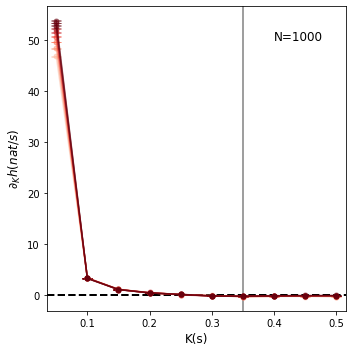

In [11]:
ks = 10
plt.figure(figsize=(5,5))
for kt in range(len(T_range)):
    mean,cil,ciu = stats.bootstrap(hdiff[kt][:10,ks,:].T,n_times=100)
    plt.errorbar(K_range[:10]*dt,mean,[mean-cil,ciu-mean],marker='o',capsize=5,ms=5,c=colors_[kt],alpha=.5)
plt.axhline(0,ls='--',c='k',lw=2)
plt.xlim(0.035,0.515)
plt.xlabel('K(s)',fontsize=12)
plt.axvline(7*dt,c='gray')
plt.ylabel('$\partial_K h (nat/s)$',fontsize=12)
plt.text(.4,50,'N={}'.format(seed_range[ks]),fontsize=12)
plt.tight_layout()
# plt.savefig('h_diff_DW.pdf')
plt.show()

# FigS1B

In [12]:
def bootstrap(l,n_times,n_samples,confidence_interval=95):
    per=(100-confidence_interval)/2
    new_means=[]
    for i in range(n_times):
        new_list=np.random.choice(l,n_samples,replace=True)
        new_means.append(ma.mean(new_list,axis=0))
    new_means=ma.vstack(new_means)
    cil=np.zeros(new_means.shape[1])
    ciu=np.zeros(new_means.shape[1])
    for i in range(new_means.shape[1]):
        cil[i]=np.nanpercentile(new_means[:,i].filled(np.nan),per)
        ciu[i]=np.nanpercentile(new_means[:,i].filled(np.nan),100-per)
    cil = ma.masked_array(cil, np.isnan(cil))
    ciu = ma.masked_array(ciu, np.isnan(ciu))
    return ma.mean(l,axis=0),cil,ciu

In [13]:
import findiff


mean_E_kin_phspace = np.zeros((len(T_range),3))
for kt,k_B_T in enumerate(T_range):
    f = h5py.File(dir_path+'DoubleWell/embedding/phspace_k_B_T_{}.h5'.format(k_B_T),'r')
    traj_matrix = np.array(f['traj_matrix'])
    f.close()
    f = h5py.File(dir_path+'DoubleWell/simulations/simulation_k_B_T_{}.h5'.format(k_B_T),'r')
    sim = np.array(f['simulation'])
    f.close()

    coefs = findiff.coefficients(deriv=1, acc=6)
    deriv_array = coefs['center']['coefficients']
    
    v_estim = (traj_matrix.dot(deriv_array))/dt
    mean_E_kin_phspace[kt] = bootstrap((v_estim**2)/2,n_times=1000,n_samples=10000)
    print(k_B_T,mean_E_kin_phspace[kt])

0.5 [0.24580872 0.23929694 0.25219949]
0.75 [0.36877045 0.35857633 0.37948937]
1.0 [0.49194087 0.47934805 0.50585709]
1.25 [0.61557392 0.59806666 0.63249459]
1.5 [0.73807404 0.71733848 0.75666626]
1.75 [0.86124886 0.83784446 0.88363694]
2.0 [0.98400078 0.95640219 1.01239524]
2.25 [1.10472636 1.07526965 1.13542112]
2.5 [1.23222654 1.19830527 1.26731479]


(2, 9)


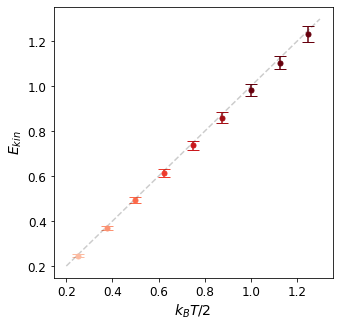

In [14]:
Tmin=0
scaled_T = (T_range - Tmin) / T_range.ptp()

colors_ = plt.cm.Reds(scaled_T)

plt.figure(figsize=(5,5))

y_err = np.array([mean_E_kin_phspace[:,0]-mean_E_kin_phspace[:,1],mean_E_kin_phspace[:,2]-mean_E_kin_phspace[:,0]])
print(y_err.shape)
kt=0
for kt in range(len(T_range)):
    plt.errorbar(T_range[kt]/2,mean_E_kin_phspace[kt,0],yerr = [[y_err[0][kt]],[y_err[1][kt]]],fmt='o',capsize=6,
             ms=5,c=colors_[kt])
plt.plot(np.arange(.2,1.4,.1),np.arange(.2,1.4,.1),ls='--',c='k',alpha=.2)
plt.xlabel('$k_BT/2$',fontsize=14)
plt.ylabel(r'$E_{kin}$',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig('equipartition_K_6_order_6_withT.pdf')
plt.show()